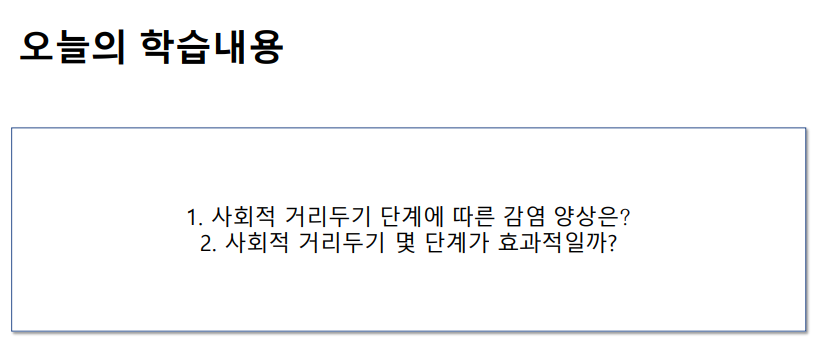

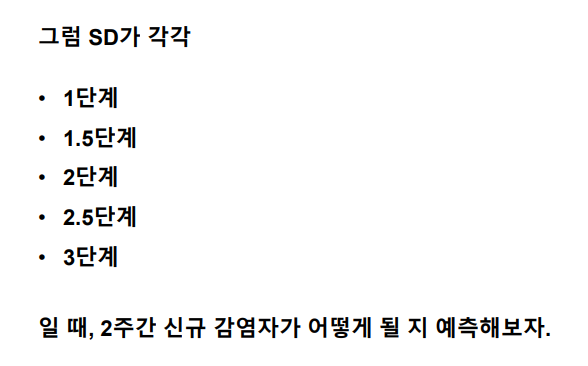

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import basinhopping

In [3]:
# 변수들을 정의하자
# 시간
t0 = 0 # 시작시간
tf = 15 # 끝시간
n = 150 # 격자 개수 
h = (tf-t0) / n # 격자 간격
N = 51840000
alpha = 1/5 # 잠복기
gamma = 1/14 # 회복률
delta = 1/229 # 1/재감염 평균일수
time = np.linspace(t0, tf, n+1) # 시작점, 끝점, 점의 개수(간격수 + 1)의 3지 변수로 벡터를 생성할 수 있다.
#               행렬생성
#                            S        E     I    R
initial_value = np.array([51839994.0, 0.0, 6.0, 0.0])

In [4]:
def f(u, beta): 
    S, E, I, R = u # u = x[i] 
    res = np.zeros(4)
    res[0] = -beta * S * I/N + delta * R
    res[1] = beta * S * I/N - alpha * E
    res[2] = alpha * E - gamma * I
    res[3] = gamma * I - delta * R
    return res

In [5]:
def rk4(f, initial_value, t0, tf, n, beta):
    time = np.linspace(t0, tf, n+1)
    x = np.array((n+1)*[initial_value])
    h = time[1] - time[0]
    for i in range(n):
        k1 = f(x[i], beta) # f(x[0]) => f(51839994, 6, 0)
        k2 = f(x[i] + 0.5 * k1 * h, beta)
        k3 = f(x[i] + 0.5 * k2 * h, beta)
        k4 = f(x[i] + k3 * h, beta)
        x[i+1] = x[i] + h * (k1 + 2 * (k2 + k3) + k4) / 6
    return x

In [6]:
def sse(model, N0, data_record, t0, tf, n):
    def result(x):
        Nt = rk4(f, initial_value, t0, tf, n, x)
        SIN = alpha * Nt[:, 1]
        SN_t = SIN[0:n+1:int(n/(tf-t0))]
        diff = data_record - SN_t
        MSE = np.dot(diff, diff)/len(diff)
        return MSE
    return result

In [7]:
# pd.read_excel로 xlsx파일 불러오기
data = pd.read_excel('Cases(COVID-19)_test2.xlsx')
data

,date,cases
0,2020-08-01,6
1,2020-08-02,6
2,2020-08-03,15
3,2020-08-04,14
4,2020-08-05,22
5,2020-08-06,19
6,2020-08-07,34
7,2020-08-08,17
8,2020-08-09,17
9,2020-08-10,29


In [8]:
data_y = data.loc[0:15, 'cases']
data_y

0       6
1       6
2      15
3      14
4      22
5      19
6      34
7      17
8      17
9      29
10     45
11     55
12    142
13    272
14    178
15    202
Name: cases, dtype: int64

In [9]:
bound = (0,100)
param_init = 0.75
data_record = data.loc[0:15, 'cases']
param = minimize(sse(f, initial_value, data_y, t0, tf, n),
                     param_init, method = "SLSQP", bounds  = (bound,))

C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\3251727492.py:4: RuntimeWarning: overflow encountered in multiply
  res[0] = -beta * S * I/N + delta * R
C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\3251727492.py:5: RuntimeWarning: overflow encountered in multiply
  res[1] = beta * S * I/N - alpha * E
C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\2687107351.py:7: RuntimeWarning: invalid value encountered in add
  k2 = f(x[i] + 0.5 * k1 * h, beta)
C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\3251727492.py:5: RuntimeWarning: invalid value encountered in subtract
  res[1] = beta * S * I/N - alpha * E
C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\3251727492.py:4: RuntimeWarning: invalid value encountered in add
  res[0] = -beta * S * I/N + delta * R
C:\Users\jinju\AppData\Local\Temp\ipykernel_7772\2687107351.py:10: RuntimeWarning: invalid value encountered in add
  x[i+1] = x[i] + h * (k1 + 2 * (k2 + k3) + k4) / 6


In [10]:
param

     fun: 1711.9632401884594
     jac: array([-0.01742554])
 message: 'Optimization terminated successfully'
    nfev: 29
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.15347354])

In [11]:
N_x = rk4(f, initial_value, t0, tf, n, param.x)

In [12]:
# 2주간 예측
beta = param.x
t02 = 15
tf2 = 29
n2 = 140
initial_value2 = N_x[150]
time_2 = np.linspace(t02, tf2, n2+1)

In [13]:
import math

In [14]:
def beta_SD(SD):
    return math.sin(math.pi*(SD-1)/4)

In [15]:
def SD_f(u, SD):
    S, E, I, R = u
    res=np.zeros(4)
    res[0] = -beta * (1-beta_SD(SD)) * S * I/N + delta * R
    res[1] = beta * (1-beta_SD(SD)) * S * I/N - alpha * E
    res[2] = alpha * E - gamma * I
    res[3] = gamma * I - delta * R
    return res

In [16]:
result = pd.DataFrame()

In [17]:
for i in np.linspace(1, 3, 5):
    temp = rk4(SD_f, initial_value2, t02, tf2, n2, i)
    result['SD_' + str(i)] = alpha * temp[:,1]

In [18]:
N_x[:,1]

array([0.00000000e+00, 6.83022110e-01, 1.34921289e+00, 2.00044561e+00,
       2.63851143e+00, 3.26512545e+00, 3.88193236e+00, 4.49051189e+00,
       5.09238389e+00, 5.68901320e+00, 6.28181422e+00, 6.87215531e+00,
       7.46136294e+00, 8.05072564e+00, 8.64149776e+00, 9.23490307e+00,
       9.83213821e+00, 1.04343759e+01, 1.10427683e+01, 1.16584496e+01,
       1.22825393e+01, 1.29161451e+01, 1.35603650e+01, 1.42162905e+01,
       1.48850087e+01, 1.55676051e+01, 1.62651656e+01, 1.69787790e+01,
       1.77095394e+01, 1.84585479e+01, 1.92269155e+01, 2.00157643e+01,
       2.08262305e+01, 2.16594659e+01, 2.25166399e+01, 2.33989419e+01,
       2.43075832e+01, 2.52437986e+01, 2.62088490e+01, 2.72040229e+01,
       2.82306388e+01, 2.92900469e+01, 3.03836313e+01, 3.15128121e+01,
       3.26790473e+01, 3.38838349e+01, 3.51287154e+01, 3.64152733e+01,
       3.77451398e+01, 3.91199951e+01, 4.05415703e+01, 4.20116497e+01,
       4.35320739e+01, 4.51047412e+01, 4.67316110e+01, 4.84147057e+01,
      

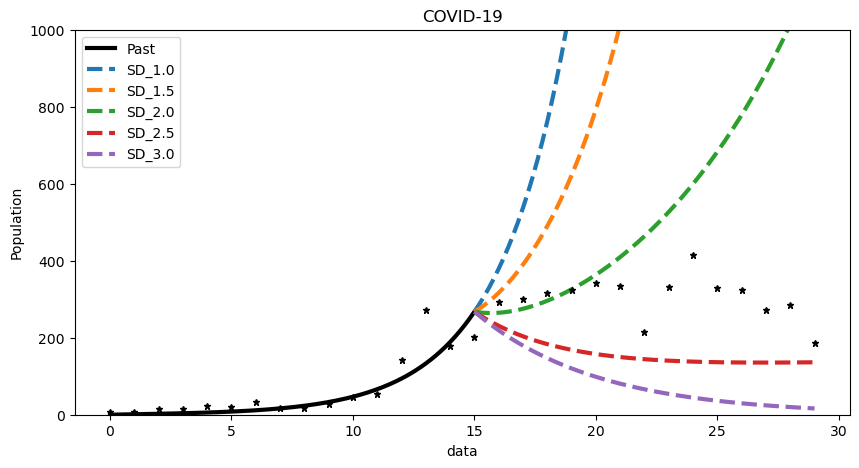

In [19]:
plt.figure(figsize = (10, 5))
t1 = time
y1 = alpha * N_x[:,1]
lines = plt.plot(t1, y1, 'k')
plt.setp(lines, linewidth = 3)
for i in np.linspace(1, 3, 5):
    temp = result['SD_' + str(i)]
    lines = plt.plot(time_2, temp, '--')
    plt.setp(lines, linewidth = 3)

lines = plt.plot(data.index, data['cases'], '*k')
plt.setp(lines, markersize = 5)
plt.ylim([0,1000])    
plt.xlabel('data')
plt.ylabel('Population')
plt.legend(('Past', 'SD_1.0', 'SD_1.5', 'SD_2.0', 'SD_2.5', 'SD_3.0'), fontsize = 10, loc = 'best')
plt.title('COVID-19')
plt.show()

In [20]:
beta

array([1.15347354])

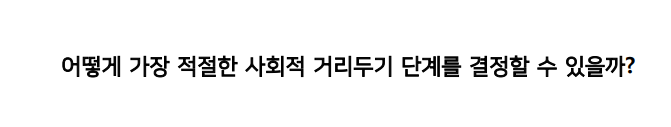

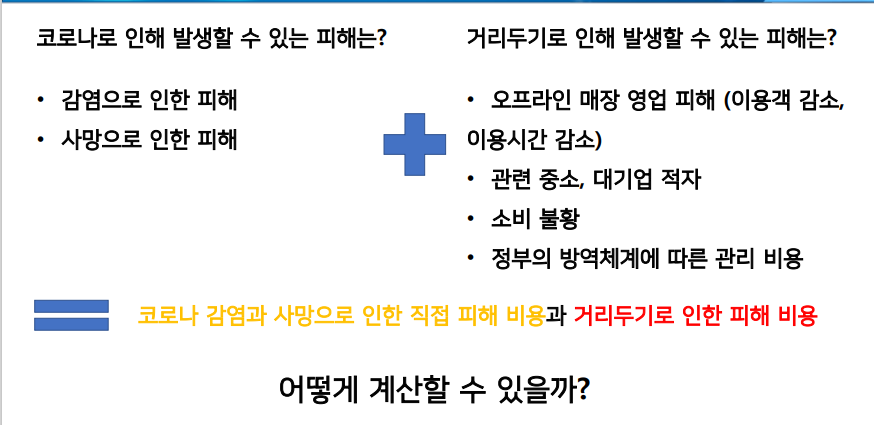

In [21]:
# C = 봉쇄비용이라 가정
def cost_SD(C, SD):
    return (C*(SD-1)**2) / 4

In [22]:
def TC(model, N0, t0, tf, n, C):
    def Total_cost(x):
        Nt = rk4(model, N0, t0, tf, n, x)
        SNI = alpha * Nt[:,1]
        SN_t = SNI[0:n+1:int(n/(tf-t0))] # 나누기는 실수로나와서 정수형태로 변환
        cost = 0.44 * SN_t.sum() + (tf-t0+1) * cost_SD(C, x)
        return cost
    return Total_cost

In [23]:
C = [100, 250, 500, 1000, 2000]
optimal_SD = np.zeros(5)
result_optimal = pd.DataFrame()

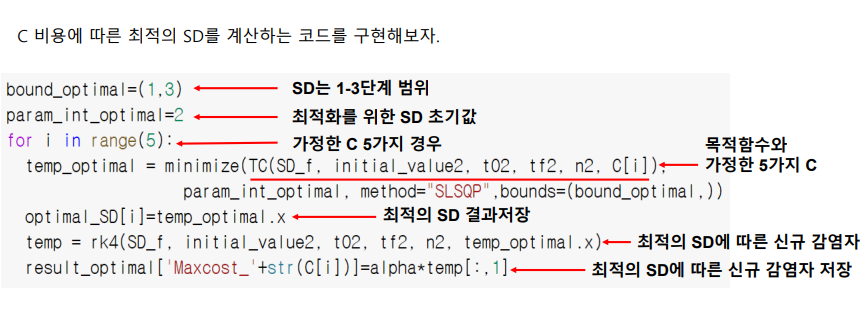m

In [24]:
bound_optimal = (1,3)
param_int_optimal = 2
for i in range(5):
    temp_optimal = minimize(TC(SD_f, initial_value2, t02, tf2, n2, C[i]),
                           param_int_optimal, method = "SLSQP", bounds = (bound_optimal,))
    optimal_SD[i] = temp_optimal.x
    temp = rk4(SD_f, initial_value2, t02, tf2, n2, temp_optimal.x)
    result_optimal['Maxcost_' + str(C[i])] = alpha * temp[:,1]

In [25]:
optimal_SD

array([2.66077981, 2.43483496, 2.2522283 , 2.07006503, 1.89196713])

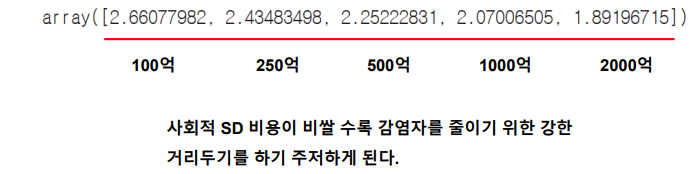

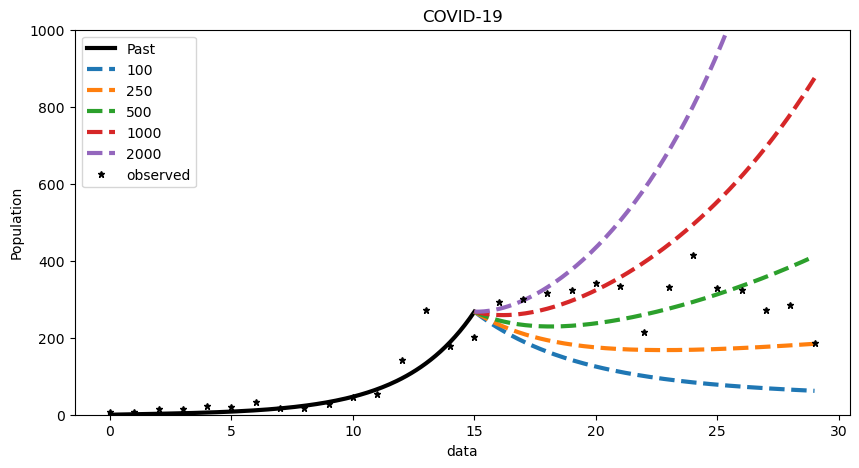

In [26]:
plt.figure(figsize = (10, 5))
t1 = time
y1 = alpha * N_x[:,1]
lines = plt.plot(t1, y1, 'k')
plt.setp(lines, linewidth = 3)
t2 = time_2
for i in range(5):
    temp = result_optimal['Maxcost_' + str(C[i])]
    lines = plt.plot(t2, temp, '--')
    plt.setp(lines, linewidth = 3)
t3 = data.index
y3 = data["cases"]
lines = plt.plot(t3, y3, '*k')
plt.setp(lines, markersize = 5)
plt.ylim([0,1000])    
plt.xlabel('data')
plt.ylabel('Population')
plt.legend(('Past', '100', '250', '500', '1000', '2000', 'observed'), fontsize = 10, loc = 'best')
plt.title('COVID-19')
plt.show()